## Sales Forecasting <br/><br/>

#### About the data:

> This notebook is used to forecast the next 3 months’ sales based on randomly generated [ dummy ] historical data spanning from January 01, 2021 to March 01, 2023. <br/><br/>

> The product names were extracted from a CSV file containing shipment information. ‘ProductABC123’ will be used as an example in the code below <br/><br/>

#### Objectives:

> The goal here is to use time series analysis techniques to generate sales predictions which will be used to aid in business decisions. <br/><br/>

> We will examine the existing trend and seasonality in the dataset before building, training, and evaluating a model. <br/><br/>

#### Conclusion:

> Among the 3 models evaluated, the arima model which incorporates the manual hyperparameter tuning, yielded the best root mean squared error [RMSE] and mean absolute error [MAE]. <br/><br/>

> The RMSE of the arima model is 7.91, indicating that the predictions were off by an average of 7.91 units. <br/><br/>

> This is lower than the RMSE of the baseline mode [random walk model] which is at 11.81. <br/><br/>

> Note that a walk forward validation is used to optimize both the Auto Arima and Arima models in part 3. <br/><br/> 



In [1]:
#import usual libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
#import the dataset
products_df = pd.read_csv("../../Projects_data/6.practice_files/Practice_file_1.csv", parse_dates=True)

#remove unnecessary columns from the dataframe 
products_df = products_df.drop([products_df.columns[10], products_df.columns[12], products_df.columns[16], products_df.columns[17]], axis=1)
products_df.head()

,Product Name,Order number,Market Place,Quantity,Shipping Cost/Unit,Production Cost/Unit,Total Cost/Unit (COGS),Total Order Cost,Production Lead Time (Days),Production Should be Ready in,Estimated Departure Date,Actual Lead Time,Shipping Lead Time,Shipping Route
0,ProductABC123,1st,Canada,300,$0.28,$2.34,$2.62,$787.30,33,6/1/2020,15-Jan-2020,89.0,56,Sea
1,ProductDEF173,1st,Canada,300,$0.60,$3.91,$4.51,"$1,353.55",33,6/1/2020,15-Jan-2020,89.0,56,Sea
2,ProductGEF223,1st,Canada,300,$0.76,$3.40,$4.16,"$1,246.59",33,6/1/2020,15-Jan-2020,89.0,56,Sea
3,ProductHIJ273,1st,Canada,300,$0.60,$3.98,$4.58,"$1,374.55",33,6/1/2020,15-Jan-2020,90.0,57,Sea
4,ProductKLM323,1st,Canada,440,$1.23,$3.70,$4.93,"$2,168.00",32,20/3/2020,29-Nov-2020,107.0,75,Sea


#### Part 1: Generate random numbers to represent the monthly sales for each product

In [21]:
#generate random numbers to represent the monthly sales for each product 
np.random.seed(43)
monthly_sales_df = pd.DataFrame()
initial_sales = 300
for prod in products_df["Product Name"]:
    sales_list = [initial_sales]
    for c in range(26): 
        monthly_growth = np.random.normal(scale=0.05) #5% standard deviation 
        next_monthly_sales = sales_list[-1] * (1+monthly_growth) #previous monthly sales + random noise
        sales_list.append(next_monthly_sales)

    monthly_sales_df[prod] = sales_list

#change the data type from float to int
monthly_sales_df = monthly_sales_df.astype(int)
monthly_sales_df["Date"] = pd.date_range(start='2021-01-01', end='2023-03-01', freq='MS')
monthly_sales_df.set_index("Date", inplace=True)
monthly_sales_df

,ProductABC123,ProductDEF173,ProductGEF223,ProductHIJ273,ProductKLM323,ProductNMO373,ProductPQR423,ProductSTUV473,ProductWXY523,ProductZAA573,ProductZAB623
Date,,,,,,,,,,,
2021-01-01,300,300,300,300,300,300,300,300,300,300,300
2021-02-01,272,306,282,291,280,277,328,288,306,307,284
2021-03-01,269,293,296,281,274,278,336,275,279,287,293
2021-04-01,250,305,283,277,281,301,355,279,265,297,289
2021-05-01,259,319,278,277,283,289,344,279,282,307,300
2021-06-01,240,327,289,288,274,269,351,266,279,307,337
2021-07-01,254,334,277,289,272,288,352,271,306,319,339
2021-08-01,252,312,295,293,278,281,348,274,287,308,340
2021-09-01,264,312,286,296,277,293,328,288,288,307,312


#### Part 2: Check the trend and seasonality in the dataset

Note: If there are less than 24 months worth of data, we need to manually calculate the trend and seasonality in the dataset.

In [22]:
#moving average decomposition
def manually_check_trend_seasonality(df, product_name, rolling_window=3):
    summary_df = pd.DataFrame()

    #get the trend in the dataset 
    summary_df[product_name] = df[product_name]
    summary_df["trend"] = df[product_name].rolling(window=rolling_window, center=True).mean() #get the weighted average of a 3-month period
    summary_df["detrended"] = summary_df[product_name] - summary_df["trend"] #monthly sales - trend 

    #get the seasonality in the dataset 
    monthly_seasonality = summary_df.groupby(df.index.month)["detrended"].mean() #get the mean of the detrended values per month
    summary_df["seasonality"] = summary_df.index.month.map(monthly_seasonality)
    summary_df["seasonality"] = summary_df["seasonality"].fillna(0)

    #get the residual in the dataset
    summary_df["residual"] = summary_df[product_name] - summary_df["trend"] - summary_df["seasonality"]

    return summary_df

#manually decomposing the trend and seasonality of a dataset
trend_seasonality_df = manually_check_trend_seasonality(monthly_sales_df, "ProductABC123")
trend_seasonality_df

,ProductABC123,trend,detrended,seasonality,residual
Date,,,,,
2021-01-01,300,NaN,NaN,3.666667,NaN
2021-02-01,272,280.333333,-8.333333,0.111111,-8.444444
2021-03-01,269,263.666667,5.333333,1.833333,3.500000
2021-04-01,250,259.333333,-9.333333,-7.500000,-1.833333
2021-05-01,259,249.666667,9.333333,9.666667,-0.333333
2021-06-01,240,251.000000,-11.000000,-4.833333,-6.166667
2021-07-01,254,248.666667,5.333333,3.000000,2.333333
2021-08-01,252,256.666667,-4.666667,-7.500000,2.833333
2021-09-01,264,267.666667,-3.666667,0.500000,-4.166667


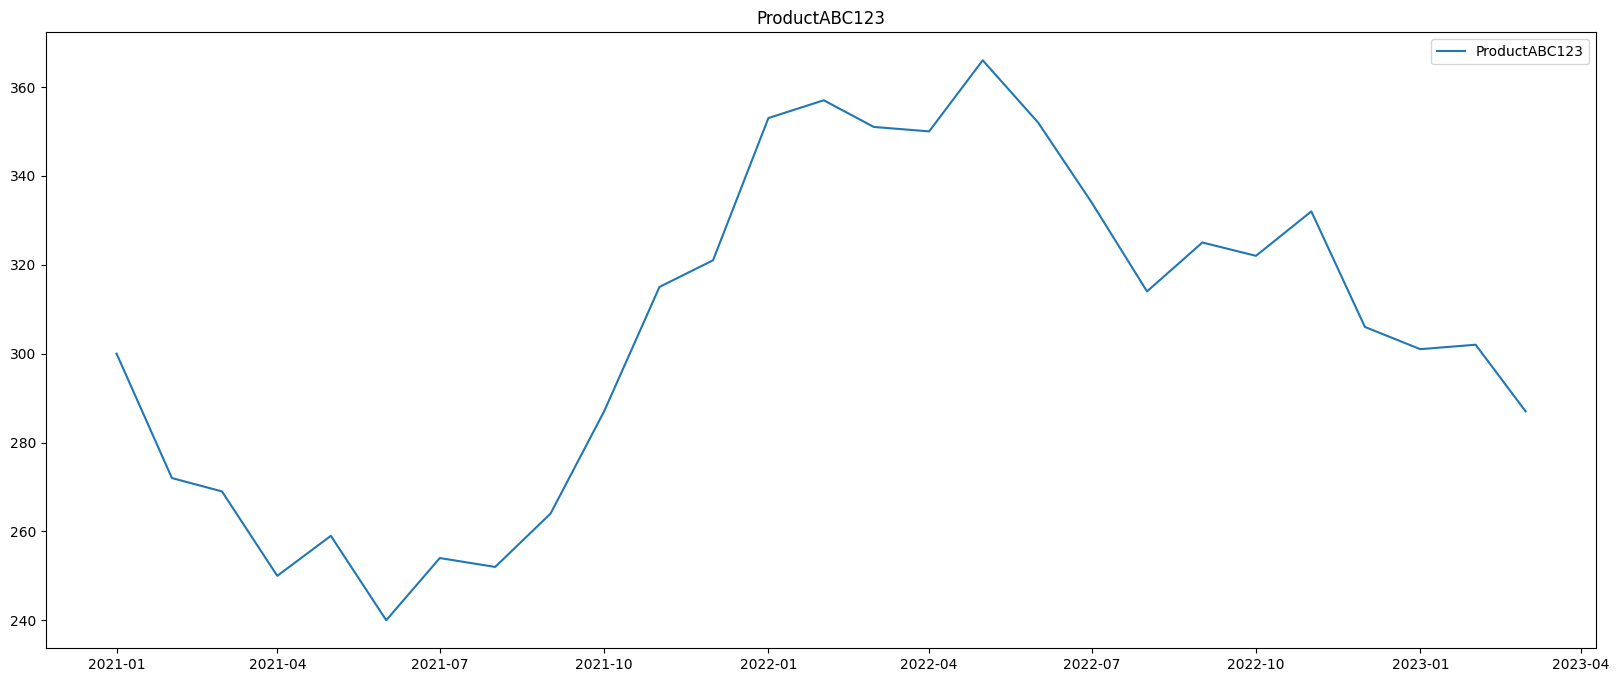

<Figure size 640x480 with 0 Axes>

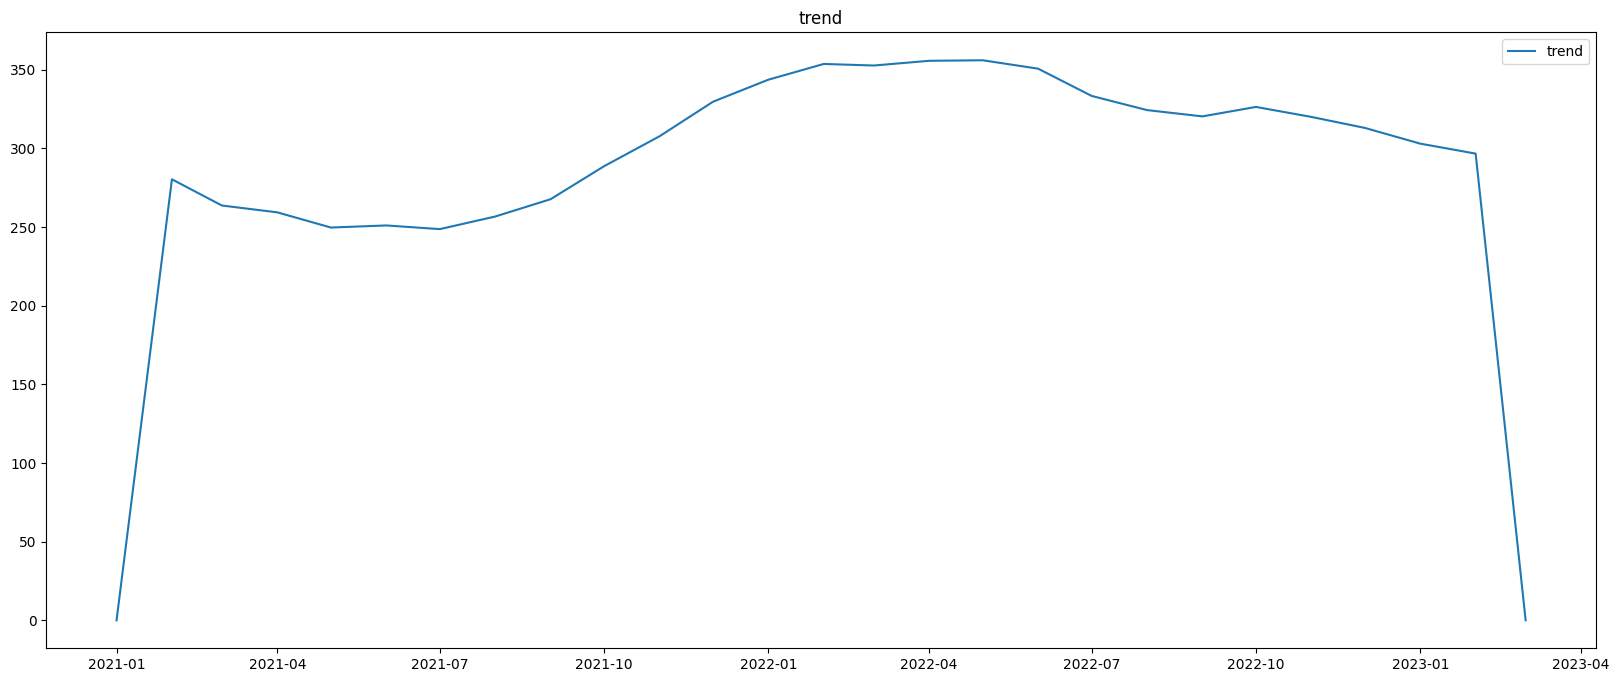

<Figure size 640x480 with 0 Axes>

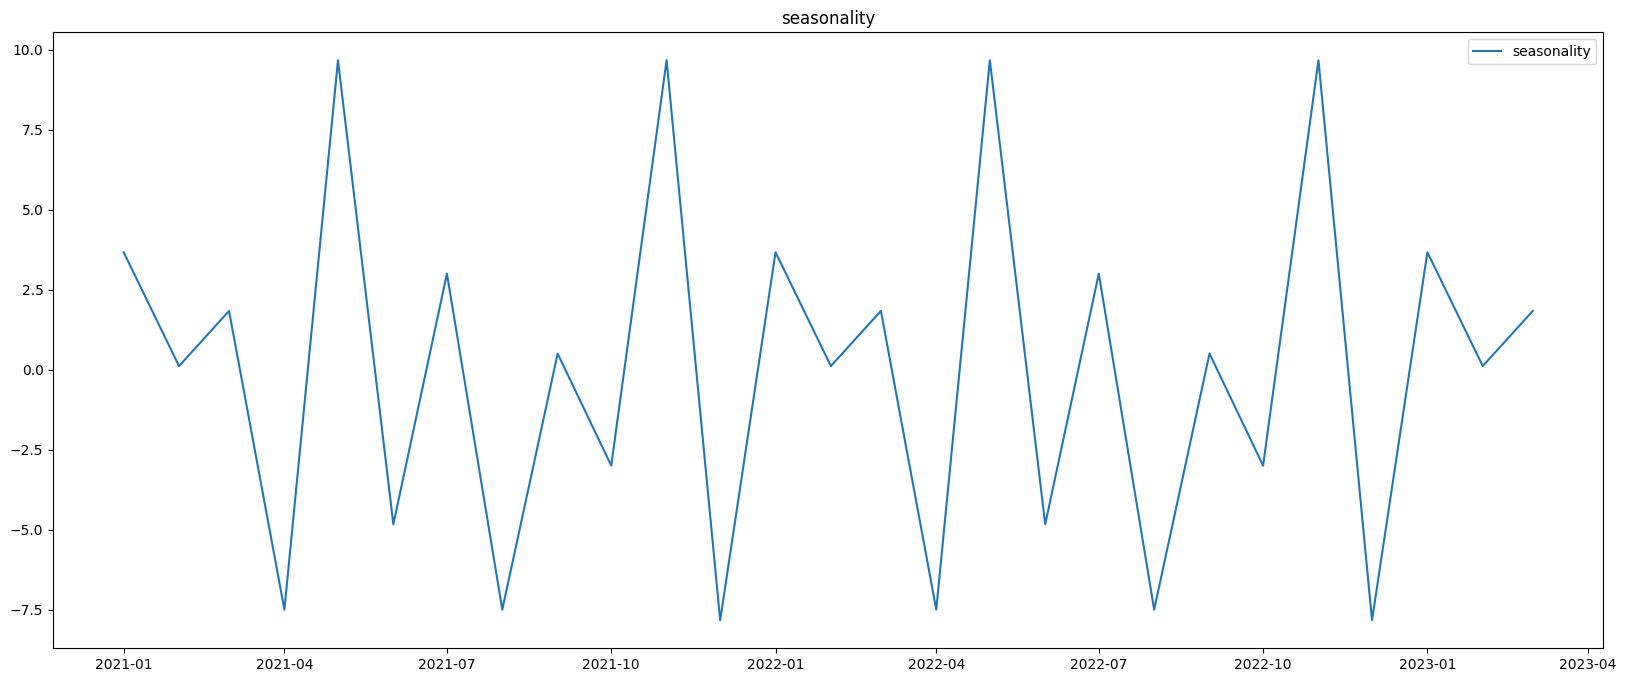

<Figure size 640x480 with 0 Axes>

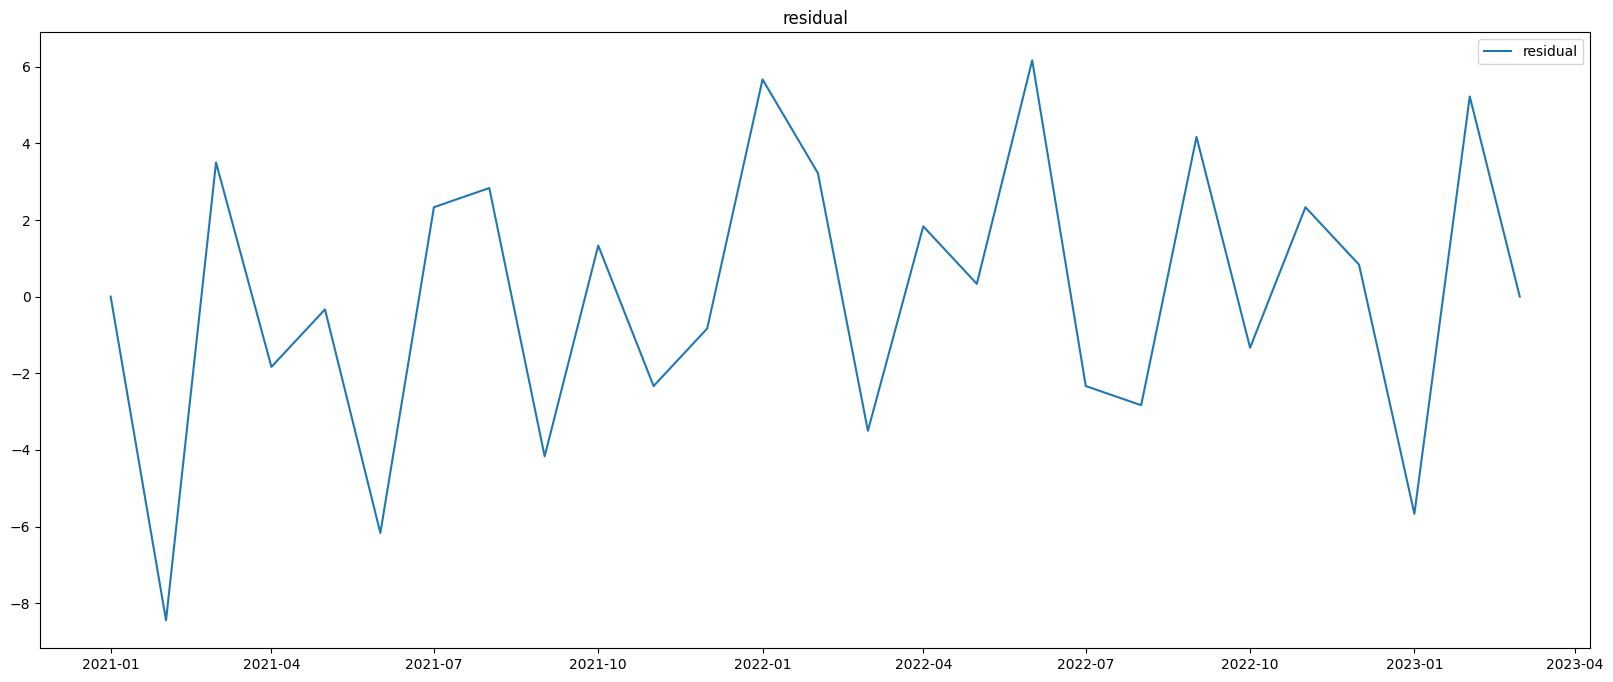

<Figure size 640x480 with 0 Axes>

In [23]:
#plot the trend, seasonality, and residuals
def plot_trend_seasonality(df):
    df = df.fillna(0)

    for col in df.columns:
        if col != "detrended":
            plt.subplots(figsize=(20,8))
            plt.plot(df[col], label=col)
            plt.title(col)
            plt.legend()

            plt.show()
            plt.tight_layout()

plot_trend_seasonality(trend_seasonality_df)

> There's an upward trend in the monthly sales of ProductABC123 from July 2021 to June 2022. </br></br>

> The seasonality graph shows that January, May, and November are the strongest months for ProductABC123. </br></br>
    
> A significant dip in sales is observed during the months of April, August, and December. </br></br>


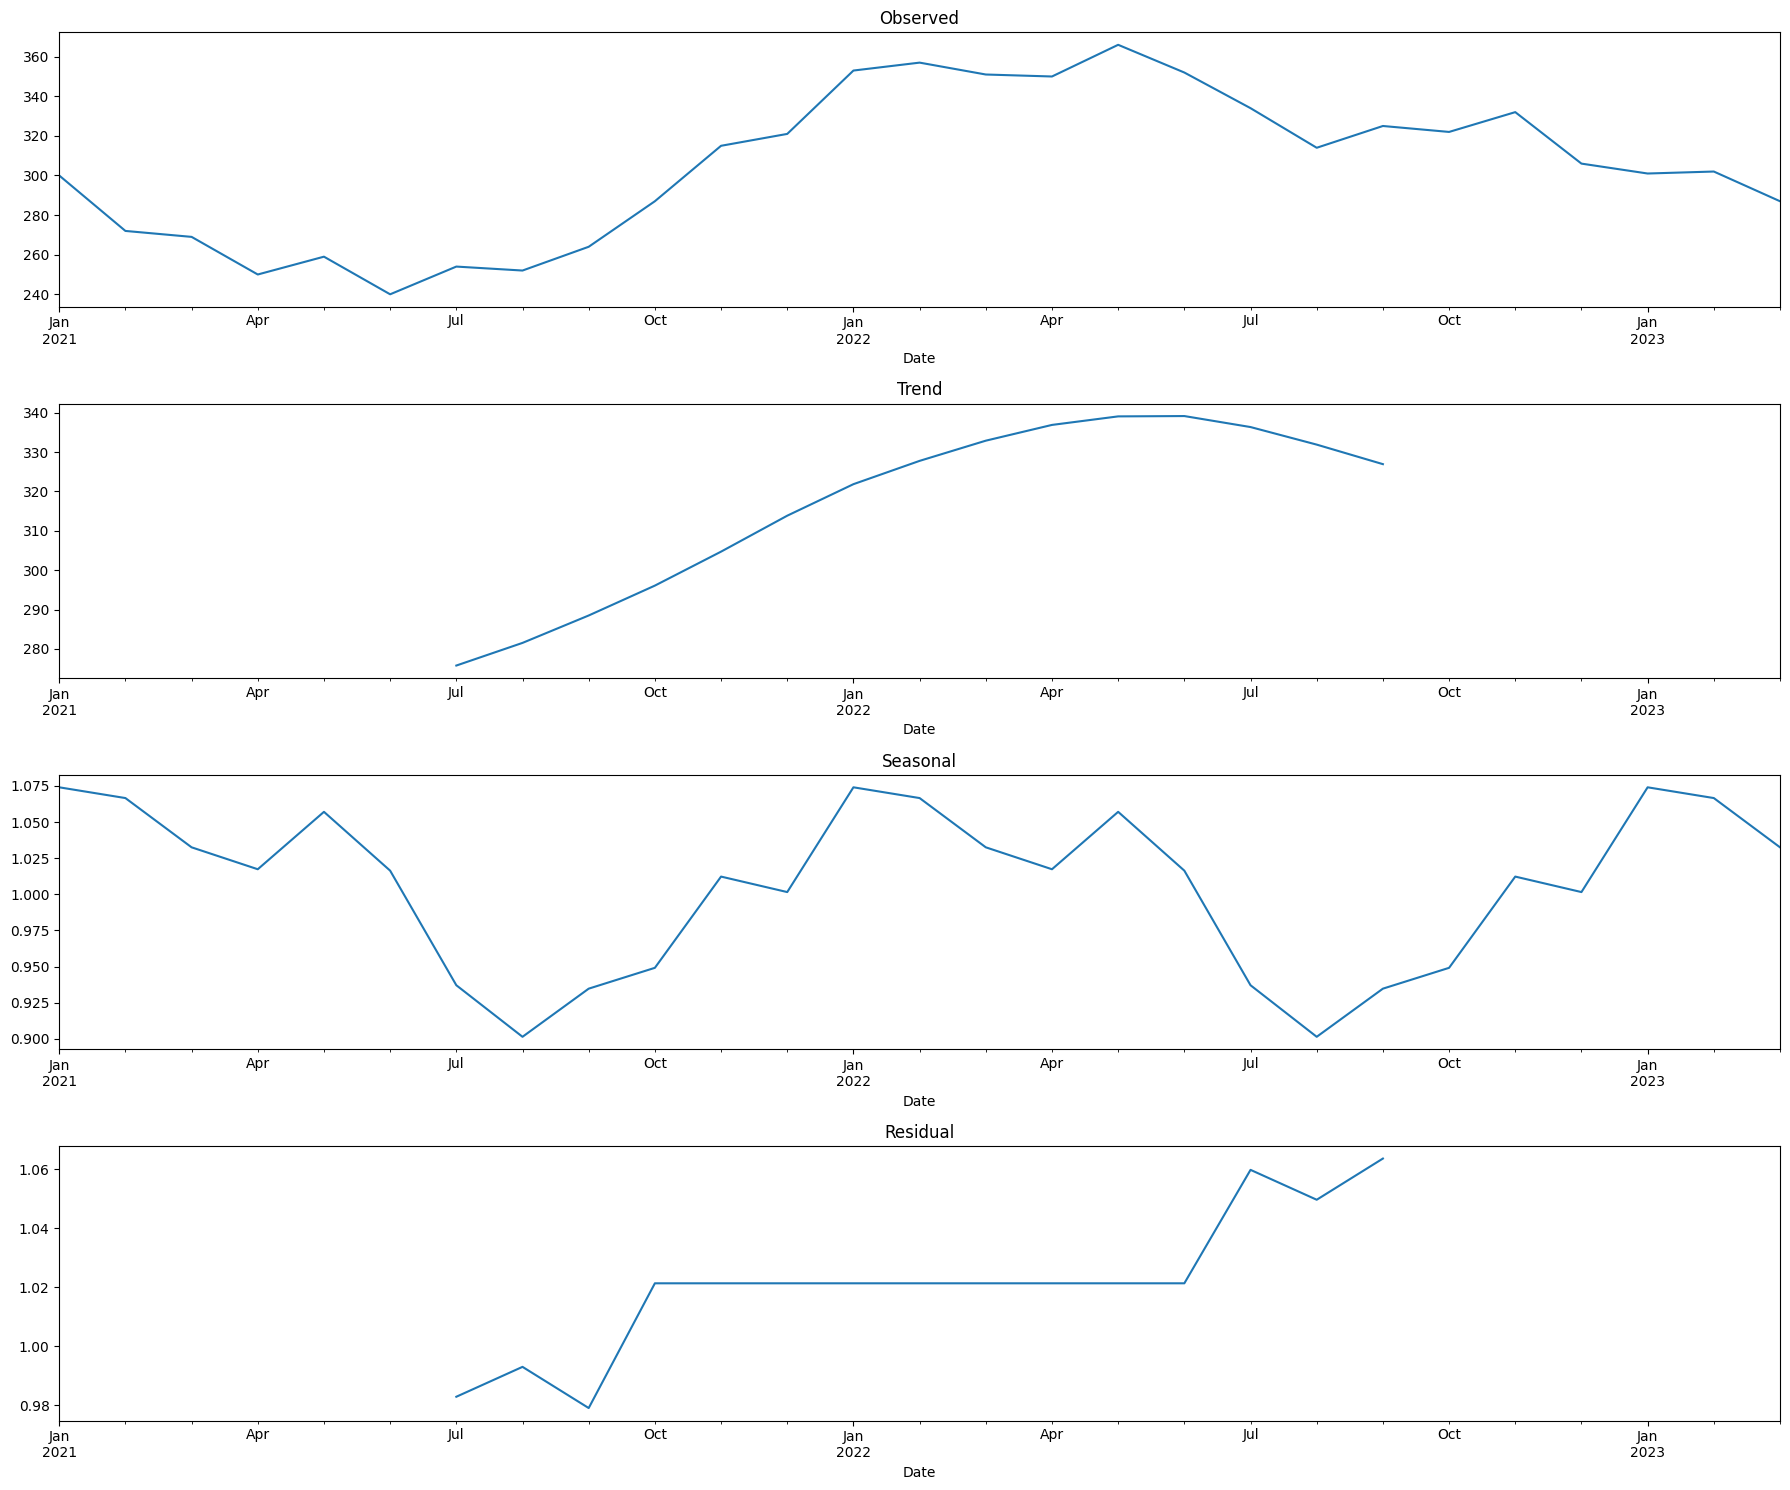

In [24]:
#use statsmodels' seasonal decompose function instead
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_sales_df['ProductABC123'], model='multiplicative')

# Plot the individual components manually
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(18,15))
decomposition.observed.plot(title='Observed', ax=ax1, legend=False)
decomposition.trend.plot(title='Trend', ax=ax2)
decomposition.seasonal.plot(title='Seasonal', ax=ax3)
decomposition.resid.plot(title='Residual', ax=ax4)

plt.tight_layout()
plt.show()


> The data still shows an upward trend in monthly sales from July 2021 to June 2022.

> The seasonality graph above also indicates strong sales during January and May, with a decline in sales in August.

> The seasonal_decompose function uses the classical decomposition method, which is more complex than the moving average decomposition method used earlier. This results in a slight difference in the graphs produced.

#### Part 3: Model training and evaluation

In [25]:
#create the train and test set
def create_train_test_set(df, product_name, test_len=3): #creates the train and test set specific to time series data
    train_df = df[product_name].iloc[:-test_len]
    test_df = df[product_name].iloc[-test_len:]
    return  train_df, test_df

train_set, test_set = create_train_test_set(monthly_sales_df, "ProductABC123")
print(f"train set size is {len(train_set)} and test set size is {len(test_set)}")

#perform log transformation to the data 
train_set_log = np.log(train_set)
test_set_log = np.log(test_set)

train set size is 24 and test set size is 3


##### Model 1: Random Walk Model

Note: We will not use the log-transformed train and test sets in the Random Walk model.

In [26]:
#create a random walk model
rw_test_pred = [train_set.iloc[-1]] * len(test_set)
random_walk_rmse = root_mean_squared_error(y_true=test_set, y_pred=rw_test_pred)
random_walk_mape = mean_absolute_percentage_error(y_true=test_set, y_pred=rw_test_pred)

print(f"The random walk model's rmse is {random_walk_rmse} and the mape is {random_walk_mape}")

The random walk model's rmse is 11.575836902790225 and the mape is 0.03201947312866013


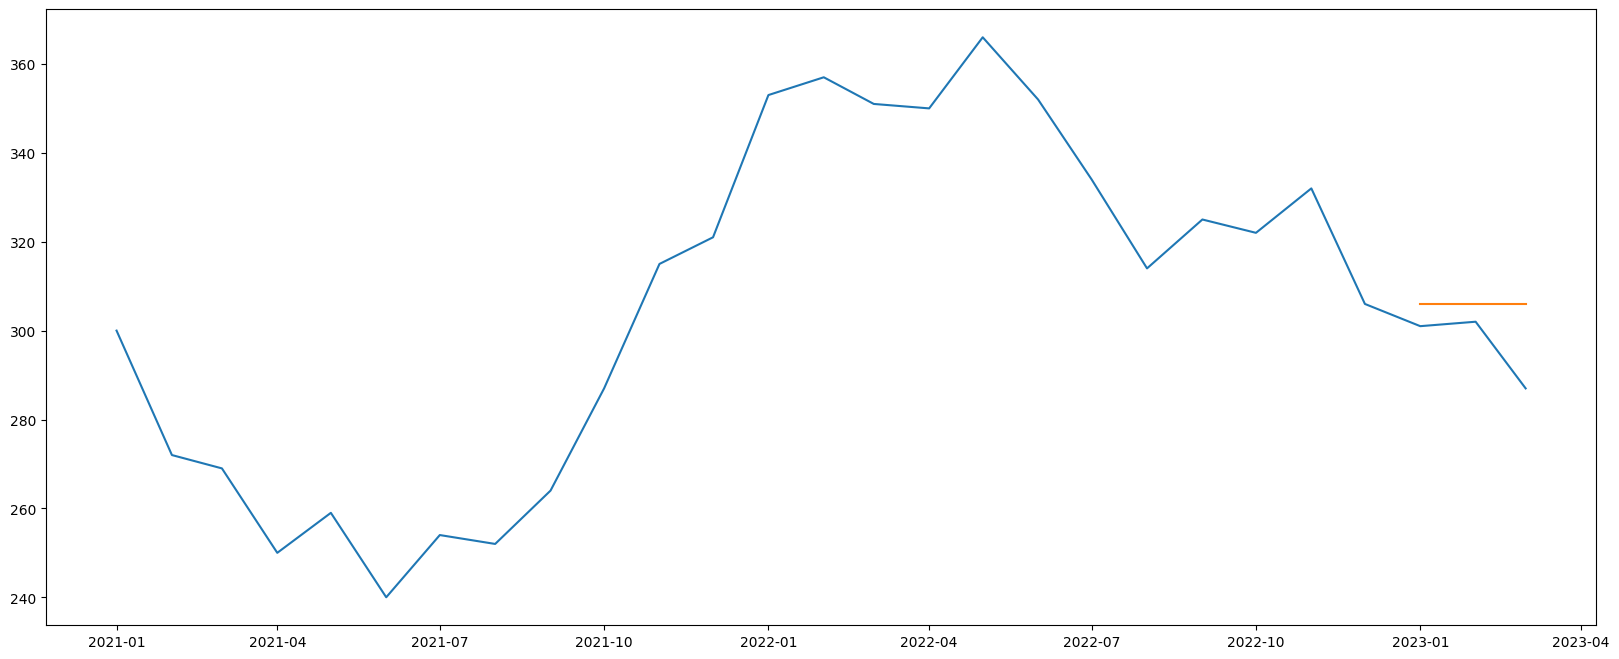

In [27]:
#plot the random walk model prediction to compare with the actual values 
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(monthly_sales_df["ProductABC123"], label="actual_data")
ax.plot(test_set.index, rw_test_pred, label="predicted_data")

> The random walk model will serve as the baseline for the other models.

##### Model 2: Auto Arima Model

In [28]:
#Note that the function below doesn't use the train and test set created earlier

import pmdarima as pm
def auto_arima_func(df, product_name, train_set_len=19, test_set_len=3, n_steps_len=3):
    #set the train and test length 
    train_len = train_set_len
    test_len = test_set_len
    n_steps = n_steps_len

    #create lists 
    rmse_list = []
    aic_list = []
    best_params = []

    for c in range(n_steps):
        #check if there are null values in the train set
        train_df = np.log(df[product_name].iloc[:train_len+c])
        test_df = df[product_name].iloc[train_len+c:train_len+c+n_steps]
        auto_arima_model = pm.auto_arima(train_df,
                                         seasonal=True,
                                         suppress_warnings=True,
                                         m=12)
        #print(f"train size is: {len(train_df)}")
        #print(f"test size is: {len(test_df)}")
    
        #get the rmse
        arima_predict = np.exp(auto_arima_model.predict(n_periods=test_len))
        arima_rmse = root_mean_squared_error(y_true=test_df, y_pred=arima_predict)
        rmse_list.append(arima_rmse)
    
        #get the aic
        aic_list.append(auto_arima_model.aic())
    
        #get the best params 
        best_params.append(auto_arima_model.get_params())
    
    return rmse_list, aic_list, best_params

rmse_list, aic_list, best_params_list = auto_arima_func(df=monthly_sales_df, product_name="ProductABC123")
print(f"Here's the rmse list: {rmse_list}")
print(f"Here's the aic list: {aic_list}")

/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (7) is shorter than m (12). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "
/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have

Here's the rmse list: [41.62221877325254, 61.75390682137986, 11.818065267490534]
Here's the aic list: [-14.01015733826138, -16.583832691189805, -56.037782157113284]


> We will use the parameters from the iteration with the lowest RMSE: 11.818065267490534.

In [29]:
arima_best_params = best_params_list[2]
arima_best_params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [30]:
#using the best parameters in the auto arima model
auto_arima_model = pm.auto_arima(train_set_log, 
                                 maxiter=arima_best_params["maxiter"], 
                                 method=arima_best_params["method"],
                                 order=arima_best_params["order"],
                                 scoring=arima_best_params["scoring"], 
                                 seasonal_order=arima_best_params["seasonal_order"], 
                                 suppress_warnings=True, 
                                 with_intercept=arima_best_params["with_intercept"], 
                                 seasonal=True)

arima_test_pred, arima_conf_int = auto_arima_model.predict(len(test_set), return_conf_int=True)
arima_rmse = root_mean_squared_error(y_true=test_set, y_pred=np.exp(arima_test_pred))
arima_mape = mean_absolute_percentage_error(y_true=test_set, y_pred=np.exp(arima_test_pred))

print(f"The auto arima model's rmse is {arima_rmse} and the mape is {arima_mape}")

The auto arima model's rmse is 9.069746788274328 and the mape is 0.028719927096519382


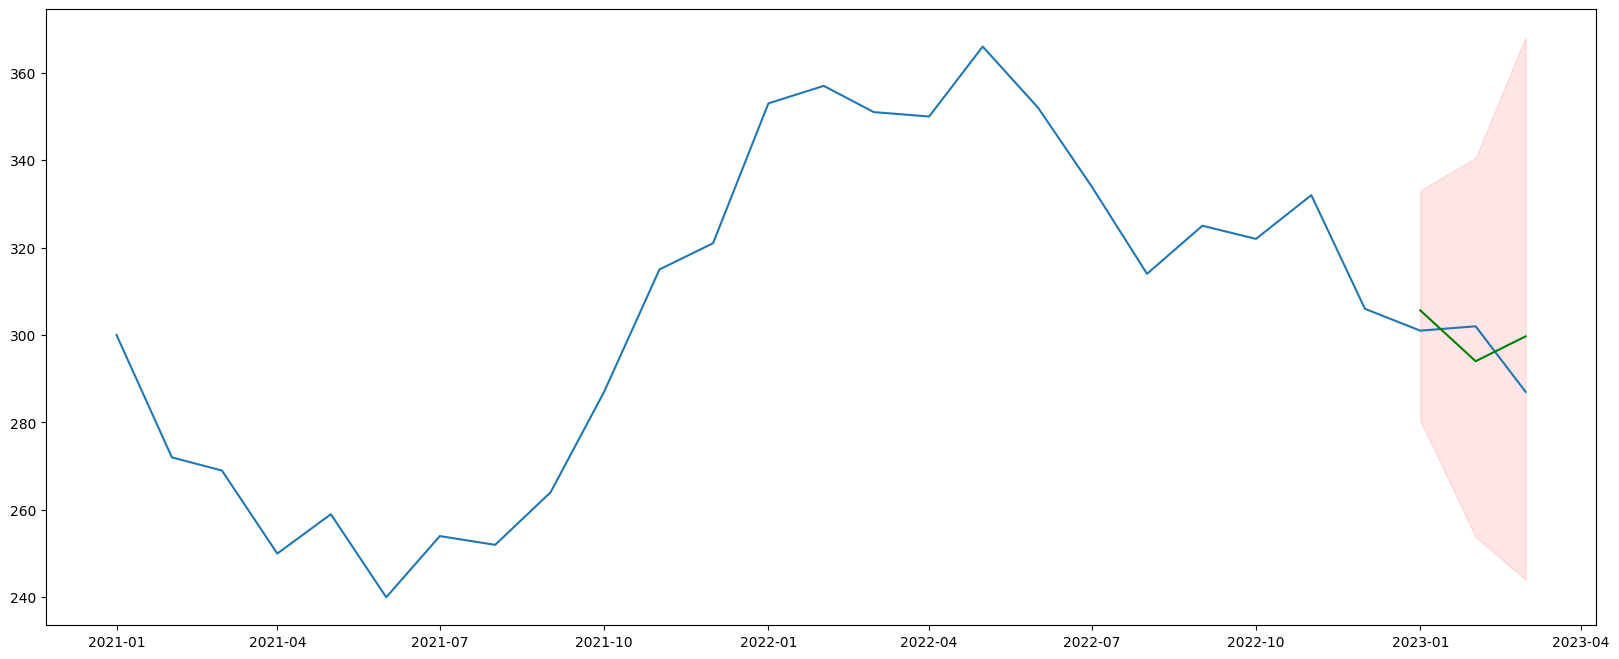

In [31]:
#get the confidence interval of the arima prediction
lower_ci = np.exp(arima_conf_int[:, 0])
upper_ci = np.exp(arima_conf_int[:, 1])
arima_test_pred = np.exp(arima_test_pred)

#plot the random walk model prediction to compare with the actual values 
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(monthly_sales_df["ProductABC123"], label="actual_data")
ax.plot(test_set.index, arima_test_pred, label="arima_predicted_data", color="green")
ax.fill_between(test_set.index, lower_ci, upper_ci, alpha=0.1, color="red")

> The auto arima model has a better rmse and mape score compared to the random walk model. 

##### Model 3: Arima Model

In [32]:
#check if the dataset is stationary using adf 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_set_log.values)

if adf_test[1] <= 0.05:
    print(f"The data is stationary. Test statistic is {adf_test[0]} and the p-value is {adf_test[1]}")
else:
    print(f"The data is not stationary. The p-value is {adf_test[1]}")

The data is stationary. Test statistic is -2.8842620459339767 and the p-value is 0.04720895423738662


In [33]:
#define the p, d, and q params 
p = list(range(6))
d = list(range(3))
q = list(range(6))
s = [12]

import itertools
order_params = list(itertools.product(p, d, q)) #different combinations of the above p, d, and q values 
seasonal_params = list(itertools.product(p, d, q, s)) #different combinations of the values above including the s variable

#create an arima function
from statsmodels.tsa.arima.model import ARIMA
def arima_func(param_order, ar_train_set, ar_test_set):
    model = ARIMA(ar_train_set,
                  order=param_order)
    ar_model = model.fit()
    ar_test_pred = ar_model.get_forecast(3)
    ar_test_pred_mean = ar_test_pred.predicted_mean
    ar_conf_low = ar_test_pred.conf_int(alpha=0.05)[:,0]
    ar_conf_upp = ar_test_pred.conf_int(alpha=0.05)[:,1]
    
    #get the rmse 
    ar_rmse_score = root_mean_squared_error(y_true=ar_test_set, y_pred=np.exp(ar_test_pred_mean))
    return ar_rmse_score, np.exp(ar_test_pred_mean), np.exp(ar_conf_low), np.exp(ar_conf_upp)

#use the above function to get the best params
n_iterations = 0
ar_best_rmse = np.inf
ar_best_order = None
conf_low = None
conf_upp = None

for x in range(len(order_params)):
    n_iterations += 1
    ar_score, ar_test_pred_mean, ar_conf_low, ar_conf_upp = arima_func(param_order=order_params[x], ar_train_set=train_set_log[:21].values, ar_test_set=np.exp(train_set_log[21:].values))
    
    if ar_score != None:
        if ar_score < ar_best_rmse:
            ar_best_rmse = ar_score
            ar_best_order = order_params[x]
            conf_low = ar_conf_low
            conf_upp = ar_conf_upp
            
print(f"The best rmse throughout the {n_iterations} iterations is {ar_best_rmse}. The order parameter used is {ar_best_order}")

/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWa

The best rmse throughout the 108 iterations is 7.911253723251613. The order parameter used is (0, 0, 3)


/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
#use the best params in the arima model
ar_rmse_score, ar_test_pred_mean, ar_conf_low, ar_conf_upp = arima_func(param_order=ar_best_order, ar_train_set=train_set_log.values, ar_test_set=np.exp(test_set_log.values))
print(f"The arima model's rmse is {ar_rmse_score}")

The arima model's rmse is 7.704625832371516


/home/apol/.config/JetBrains/DataSpell2024.1/projects/workspace/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


> The arima model from statsmodels, with manual parameter tuning, has a better rmse score compared to the other two models.

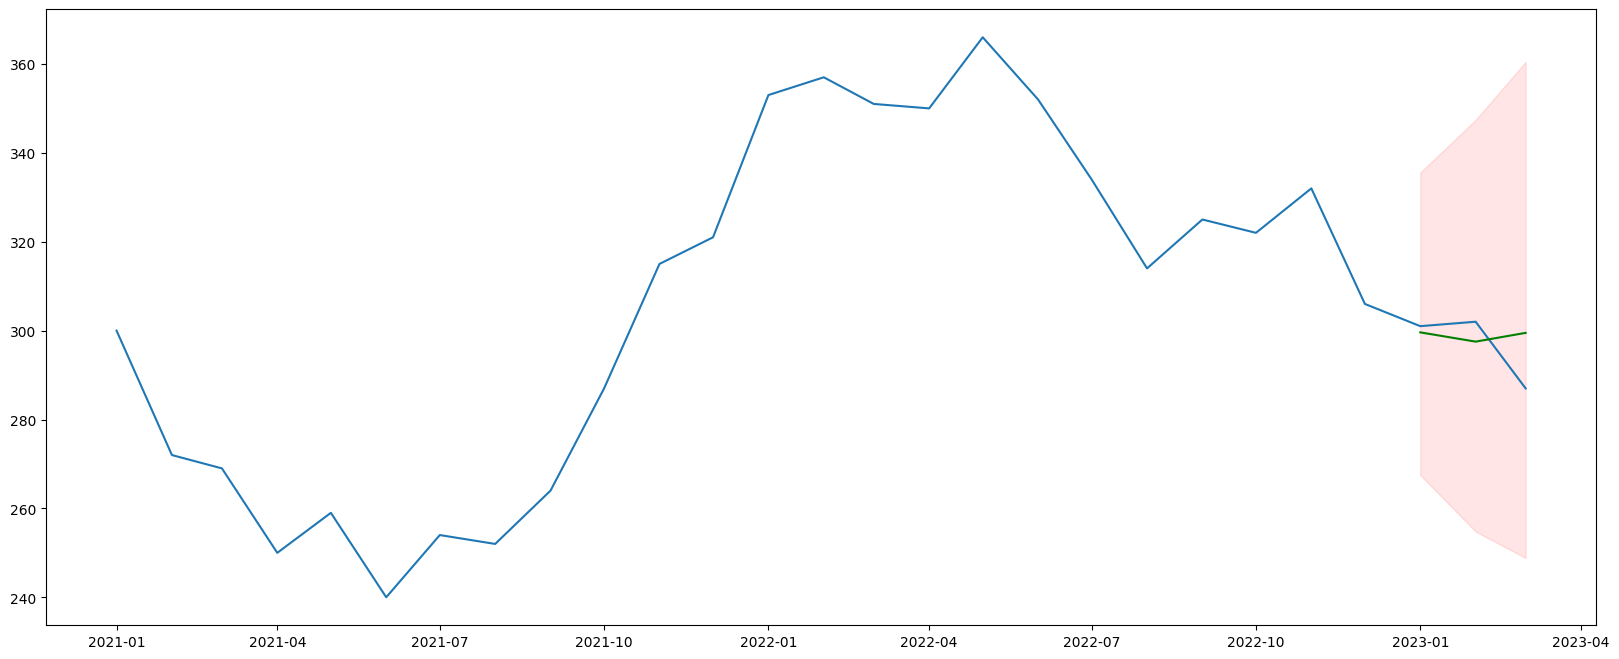

In [35]:
#plot the random walk model prediction to compare with the actual values 
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(monthly_sales_df["ProductABC123"], label="actual_data")
ax.plot(test_set.index, ar_test_pred_mean, label="arima_predicted_data", color="green")
ax.fill_between(test_set.index, ar_conf_low, ar_conf_upp, alpha=0.1, color="red")